In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Copy of Comys_Hackathon5.zip'
extract_to = '/content/comys_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

os.listdir(extract_to)
!cp -r /content/comys_data/Comys_Hackathon5 /content/

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D, BatchNormalization, Dropout

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Comys_Hackathon5/Task_A/train',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256,256))
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/Comys_Hackathon5/Task_A/val',
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256,256))

# Store class names before caching and prefetching
CLASS_NAMES = train_ds.class_names
print("Class names:", class_names)

# Extract labels from the dataset before caching and prefetching
all_labels = []
for images, labels in train_ds:
    all_labels.extend(labels.numpy())

Found 1926 files belonging to 2 classes.
Found 422 files belonging to 2 classes.
Class names: ['female', 'male']


In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights using the extracted labels
all_labels_flat = np.concatenate(all_labels)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels_flat),
    y=all_labels_flat
)

# Turn into dict form required by Keras
class_weights = {i : w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(2.4441624365482233), 1: np.float64(0.6285900783289817)}


In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])


In [ ]:

# Load base model
base_model = MobileNetV2(input_shape=(256,256)+ (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze
base_model.trainable = True

# Freeze most layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

/tmp/ipython-input-54-31262770.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(256,256)+ (3,), include_top=False, weights='imagenet')


In [ ]:
# Build final model
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),

    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,526,400 (5.82 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=5,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)


Epoch 1/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.5801 - loss: 0.6603 - val_accuracy: 0.7915 - val_loss: 0.4782
Epoch 2/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.6595 - loss: 0.5889 - val_accuracy: 0.8294 - val_loss: 0.4239
Epoch 3/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.7385 - loss: 0.5169 - val_accuracy: 0.8412 - val_loss: 0.3888
Epoch 4/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.7813 - loss: 0.4792 - val_accuracy: 0.8578 - val_loss: 0.3543
Epoch 5/5
61/61 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.8004 - loss: 0.4436 - val_accuracy: 0.8720 - val_loss: 0.3239


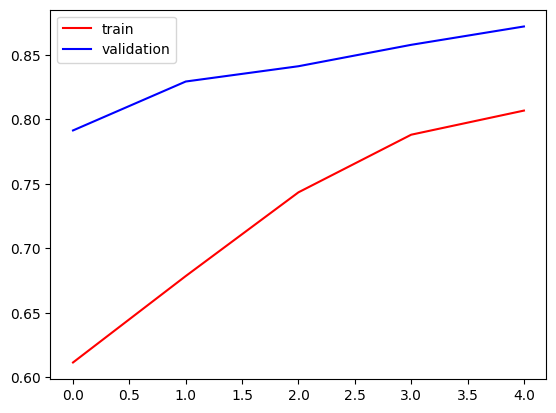

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

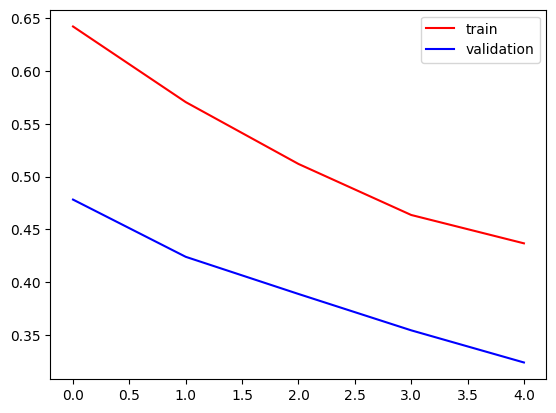

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
loss, acc = model.evaluate(validation_ds)
print(f"✅ Final Validation Accuracy: {acc * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8816 - loss: 0.3195
✅ Final Validation Accuracy: 87.20%


In [ ]:
import cv2

In [ ]:
test_img=cv2.imread('/content/Comys_Hackathon5/Task_A/val/male/009_frontal.jpg')

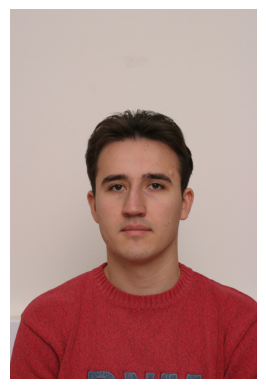

In [ ]:
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
plt.imshow(test_img_rgb)
plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess image
img_path = '/content/Comys_Hackathon5/Task_A/val/male/Aaron_Peirsol_0003.jpg'
img = image.load_img(img_path, target_size=(256, 256))  # Match your model's input
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize if you trained that way
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension → (1, 256, 256, 3)

# Predict
pred = model.predict(img_array)
print("Raw probability:", pred[0][0])

# Decode prediction
CLASS_NAMES= train_ds.class_names  # ['female', 'male']
predicted_class = CLASS_NAMES[int(pred[0][0] > 0.5)]
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Raw probability: 0.6509332
Predicted Class: male


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true, y_pred = [], []
for x_batch, y_batch in validation_ds:
    y_probs = model.predict(x_batch)
    y_preds = (y_probs > 0.5).astype("int32").flatten()
    y_true.extend(y_batch.numpy())
    y_pred.extend(y_preds)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=train_ds.class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
[[ 59  46]
 [  8 309]]
              precision    recall  f1-score   support

      female       0.88      0.56      0.69       105
        male       0.87      0.97      0.92       317

    accuracy                           0.87       422
   macro avg       0.88      0.77      0.80       422
weighted avg       0.87      0.87      0.86       422



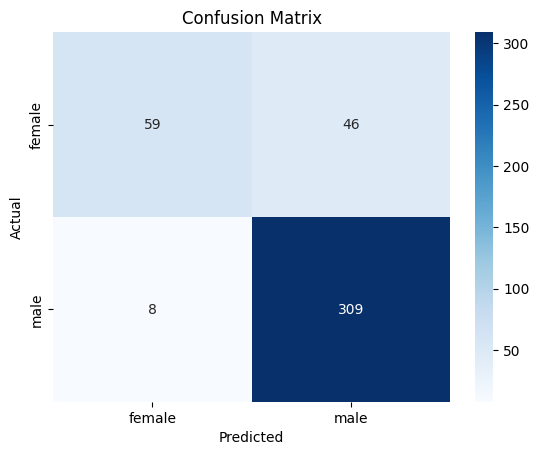

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_ds.class_names, yticklabels=train_ds.class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
